In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
import matplotlib.colors as mcolors

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
pwd

'C:\\Users\\Gary\\Partners HealthCare Dropbox\\Gurdip Uppal\\research_bwh\\MCSPACE_FINAL\\MCSPACE\\mcspace\\paper\\figures'

In [4]:
rootpath = Path("../../")
basepath = Path("./")

In [5]:
runpath = rootpath / "paper" / "mouse_runs" / "runs"

In [6]:
treepath = rootpath / "data" / "mouse_experiments" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [7]:
outpath = basepath / "figs_mouse_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model results

In [8]:
respath = get_min_loss_path(runpath, np.arange(10))

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.l

0
1
2
3
4
5
6
7
8
9
4


In [9]:
model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][10].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

C:\Users\Gary\AppData\Local\Temp\ipykernel_109200\3746714218.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(respath / MODEL_FILE)


## load taxonomy

In [10]:
taxonomy.head()

,domain,dconf,phylum,pconf,class,cconf,order,oconf,family,fconf,genus,gconf
Otu,,,,,,,,,,,,
Otu19,Bacteria,1.0,Firmicutes,1.00,Clostridia,1.00,Clostridiales,1.00,Lachnospiraceae,1.00,Faecalicatena,0.68
Otu37,Bacteria,1.0,Firmicutes,0.89,Clostridia,0.89,Clostridiales,0.89,Lachnospiraceae,0.63,Shuttleworthia,0.62
Otu24,Bacteria,1.0,Firmicutes,1.00,Clostridia,1.00,Clostridiales,1.00,Lachnospiraceae,1.00,Extibacter,0.97
Otu15,Bacteria,1.0,Firmicutes,1.00,Clostridia,1.00,Clostridiales,1.00,Lachnospiraceae,1.00,Dorea,0.36
Otu22,Bacteria,1.0,Bacteroidetes,1.00,Bacteroidia,0.97,Bacteroidales,0.97,Porphyromonadaceae,0.44,Porphyromonas,0.34


In [11]:
taxonomy = apply_taxonomy_threshold(taxonomy)

In [12]:
name_updates = {'Otu10': {'Species': 'Faecalibaculum rodentium'},
'Otu17': {'Genus': 'Roseburia'},
'Otu6': {'Species': 'Eubacterium coprostanoligenes'},
'Otu20': {'Species': 'Muribaculum gordoncarteri'},
'Otu15': {'Genus': 'Eisenbergiella'},
'Otu43': {'Family': 'Lachnospiraceae'}}

In [13]:
taxonomy['Species'] = 'na'

In [14]:
taxonomy.head()

,Domain,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu19,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Faecalicatena,na
Otu37,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Shuttleworthia,na
Otu24,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Extibacter,na
Otu15,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,na,na
Otu22,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,na,na,na


In [15]:
for oidx in name_updates.keys():
    replace = name_updates[oidx]
    key = list(replace.keys())[0]
    newname = replace[key]
    taxonomy.loc[oidx,key] = newname

In [16]:
taxonomy.loc['Otu10',:]

Domain                     Bacteria
Phylum                   Firmicutes
Class              Erysipelotrichia
Order            Erysipelotrichales
Family          Erysipelotrichaceae
Genus                Faecalibaculum
Species    Faecalibaculum rodentium
Name: Otu10, dtype: object

## Get summary results

In [17]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

In [18]:
# pert_bf, beta_summary, theta_summary, pi_summary, mean_loss = get_summary_results(model, data)
# give variables clearer names (eg theta -> assemblages; beta -> proportions)

In [19]:
thetadf.shape

(74, 76)

In [20]:
taxonomy.shape

(74, 7)

# Render figure

## settings

In [21]:
diet_colors = ['black', 'blue', 'black', 'yellow', 'black', 'red', 'black']
diets = ['S1', 'HF', 'S2', 'HFHF', 'S3', 'LP', 'S4']

In [22]:
fontsize = 12
subfontsize = 8

In [23]:
nsubj = len(subjects)
ntime = len(times)
notus, ncomm = thetadf.shape

## plot

In [84]:
ncomm_max = 120
notu_max = 110

tree_ratio = 0.1
gap_ratio = 0.15

In [85]:
theta_vmin=-2.1
theta_vmax=0
# theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
#                                              [(0,    'white'),
#                                               (0.25, 'lightyellow'),
#                                               (0.5, 'yellowgreen'),
#                                               (1,    'green')], N=256)
theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,'lightyellow'),
                                              (0.7, 'yellowgreen'),
                                              (1,    'green')], N=256)
theta_cmap.set_under('white')

theta_norm = norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)

original tree size: 1406
pruned tree size: 74


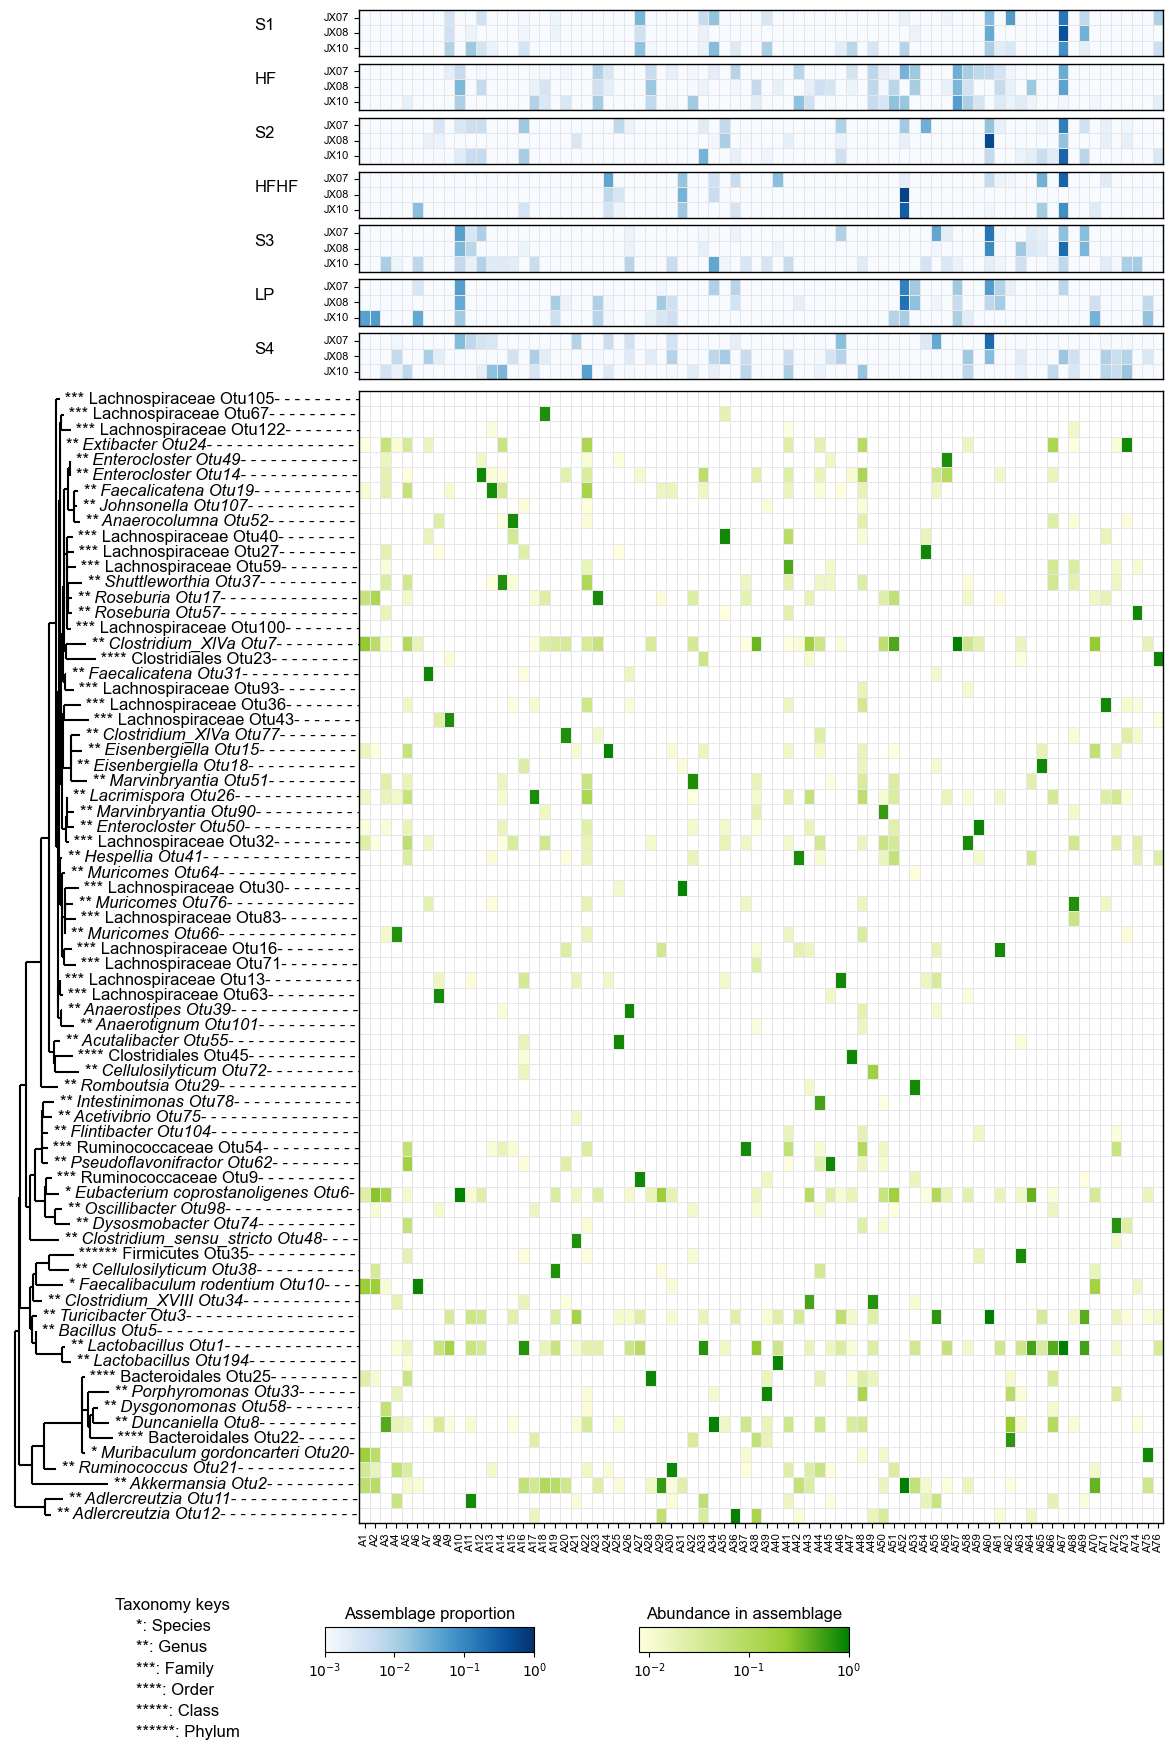

In [91]:
scale=2

lgd_ratio = 0.05
lgd_gap = 0.05

# set aspect ratios
# add buffers so scales always same?
hratios = [nsubj/notu_max]*ntime
hratios.append(notus/notu_max)
hratios.append(lgd_gap)
hratios.append(lgd_ratio)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=ntime+2+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.05)

# create subplots, get axes
ax_betas = []
for i in range(ntime):
    ax_betas.append(fig.add_subplot(gs[i,2]))
ax_tree = fig.add_subplot(gs[-4,0])

squish_ratio = 0.003
squish_hspace = 0

# create subplots, get axes
gs_theta = gs[-4,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])
    
# ax_theta = fig.add_subplot(gs[-4,2])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,2])
    
    
# plot assemlage proportions
beta_order = thetadf.columns #vis.get_abundance_order(betadf)

for i,t in enumerate(times):
    ax_betas[i]=vis.plot_all_subject_proportions_at_timepoint(ax_betas[i], betadf, t, order=beta_order, vmin=-2)
    ax_betas[i].set_xticks([])
    ax_betas[i].set_yticklabels(ax_betas[i].get_yticklabels(), rotation=0, fontsize=subfontsize)
    ax_betas[i].set_ylabel(f"{diets[i]}", rotation=0, labelpad=50, ha = 'left', fontsize=fontsize)
    ax_betas[i].set_xlabel("")
    ax_betas[i] = vis.add_border(ax_betas[i]) #, color=diet_colors[i])
    
    
# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=vis.plot_assemblages(ax_theta, thetadf, otu_order, beta_order, cmap=theta_cmap,
                                     vmin=theta_vmin, vmax=theta_vmax) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = vis.add_border(ax_theta)

# plot legend
norm = theta_norm #mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")

norm = mpl.colors.Normalize(vmin=-3, vmax=-0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0,-1,-2,-3])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', ] #'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***',
              'Order': '****', 'Class': '*****', 'Phylum': '******'} #, 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

plt.savefig(outpath / "mouse_data_full.png",bbox_inches="tight")

### increaes tree height; squish heatmap to center lines...

In [26]:
# thetadf

In [27]:
# avebeta

In [28]:
def get_subj_averaged_assemblage_proportions(betadf):
    subjave = betadf.loc[:,['Time','Assemblage','Value']].groupby(by=['Time','Assemblage']).mean()
    subjave.reset_index(inplace=True)
    betamat = subjave.pivot(index='Time', columns='Assemblage', values='Value')
    return betamat

In [29]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

## get prob cutoff

In [30]:
t = thetadf.values
b = avebeta.loc[:,thetadf.columns].values
print(t.shape)
print(b.shape)

(74, 76)
(7, 76)


In [31]:
btave = np.mean(b,axis=0)
print(btave.shape)

(76,)


In [32]:
usage = (t*btave)/np.sum(t*btave, axis=1, keepdims=True)

In [33]:
print(usage.shape)
print(usage.sum(axis=1))
print(len(usage.sum(axis=1)))

(74, 76)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
74


In [34]:
randprob = 1.0/thetadf.shape[1]
print(randprob)

0.013157894736842105


In [35]:
thetadf_psparse = thetadf.copy()
thetadf_psparse[usage<randprob] = 0

original tree size: 1406
pruned tree size: 74


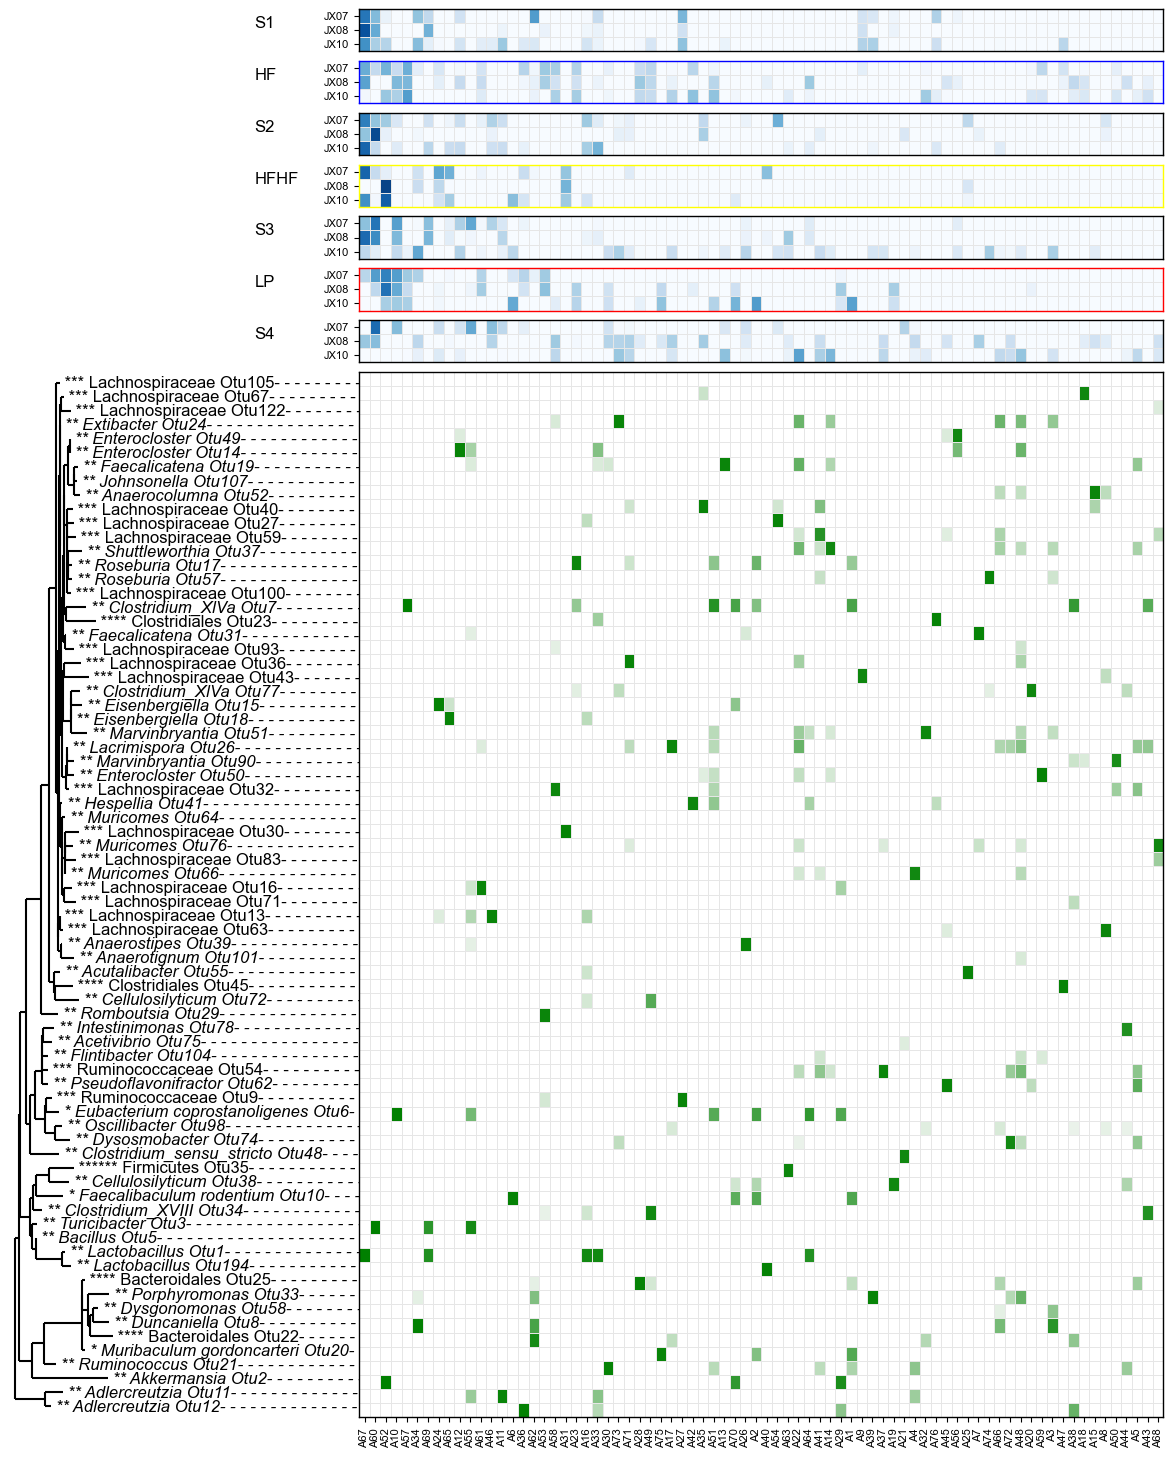

In [36]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [nsubj/notu_max]*ntime
hratios.append(notus/notu_max)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=ntime+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.05)

# create subplots, get axes
ax_betas = []
for i in range(ntime):
    ax_betas.append(fig.add_subplot(gs[i,2]))
ax_tree = fig.add_subplot(gs[-2,0])
ax_theta = fig.add_subplot(gs[-2,2])

# plot assemlage proportions
beta_order = vis.get_abundance_order(betadf)

for i,t in enumerate(times):
    ax_betas[i]=vis.plot_all_subject_proportions_at_timepoint(ax_betas[i], betadf, t, order=beta_order, vmin=-2)
    ax_betas[i].set_xticks([])
    ax_betas[i].set_yticklabels(ax_betas[i].get_yticklabels(), rotation=0, fontsize=subfontsize)
    ax_betas[i].set_ylabel(f"{diets[i]}", rotation=0, labelpad=50, ha = 'left', fontsize=fontsize)
    ax_betas[i].set_xlabel("")
    ax_betas[i] = vis.add_border(ax_betas[i], color=diet_colors[i])
    
    
# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=vis.plot_assemblages(ax_theta, thetadf_psparse, otu_order, beta_order) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = vis.add_border(ax_theta)
plt.savefig(outpath / "mouse_data_prob_cutoff_filtered.png", bbox_inches="tight")

In [37]:
thetadf_psparse.to_csv(outpath / "mouse_assemblages_prob_filtered.csv")
usagedf = pd.DataFrame(usage, index=thetadf.index, columns=thetadf.columns)
usagedf.to_csv(outpath / "otu_assemblage_probabilities.csv")

In [38]:
outpath

WindowsPath('figs_mouse_results')

## get z score cutoffs

In [39]:
# t.shape

In [40]:
t = thetadf.values

In [41]:
t.shape

(74, 76)

In [42]:
z = (t - np.mean(t,axis=1,keepdims=True))/(np.std(t, axis=1, keepdims=True))

In [43]:
z.shape

(74, 76)

In [44]:
print((z>2).sum())
print((z>3).sum())

116
95


In [45]:
theta_zsparse2 = thetadf.copy()
theta_zsparse3 = thetadf.copy()

theta_zsparse2[z<2] = 0
theta_zsparse3[z<3] = 0

original tree size: 1406
pruned tree size: 74


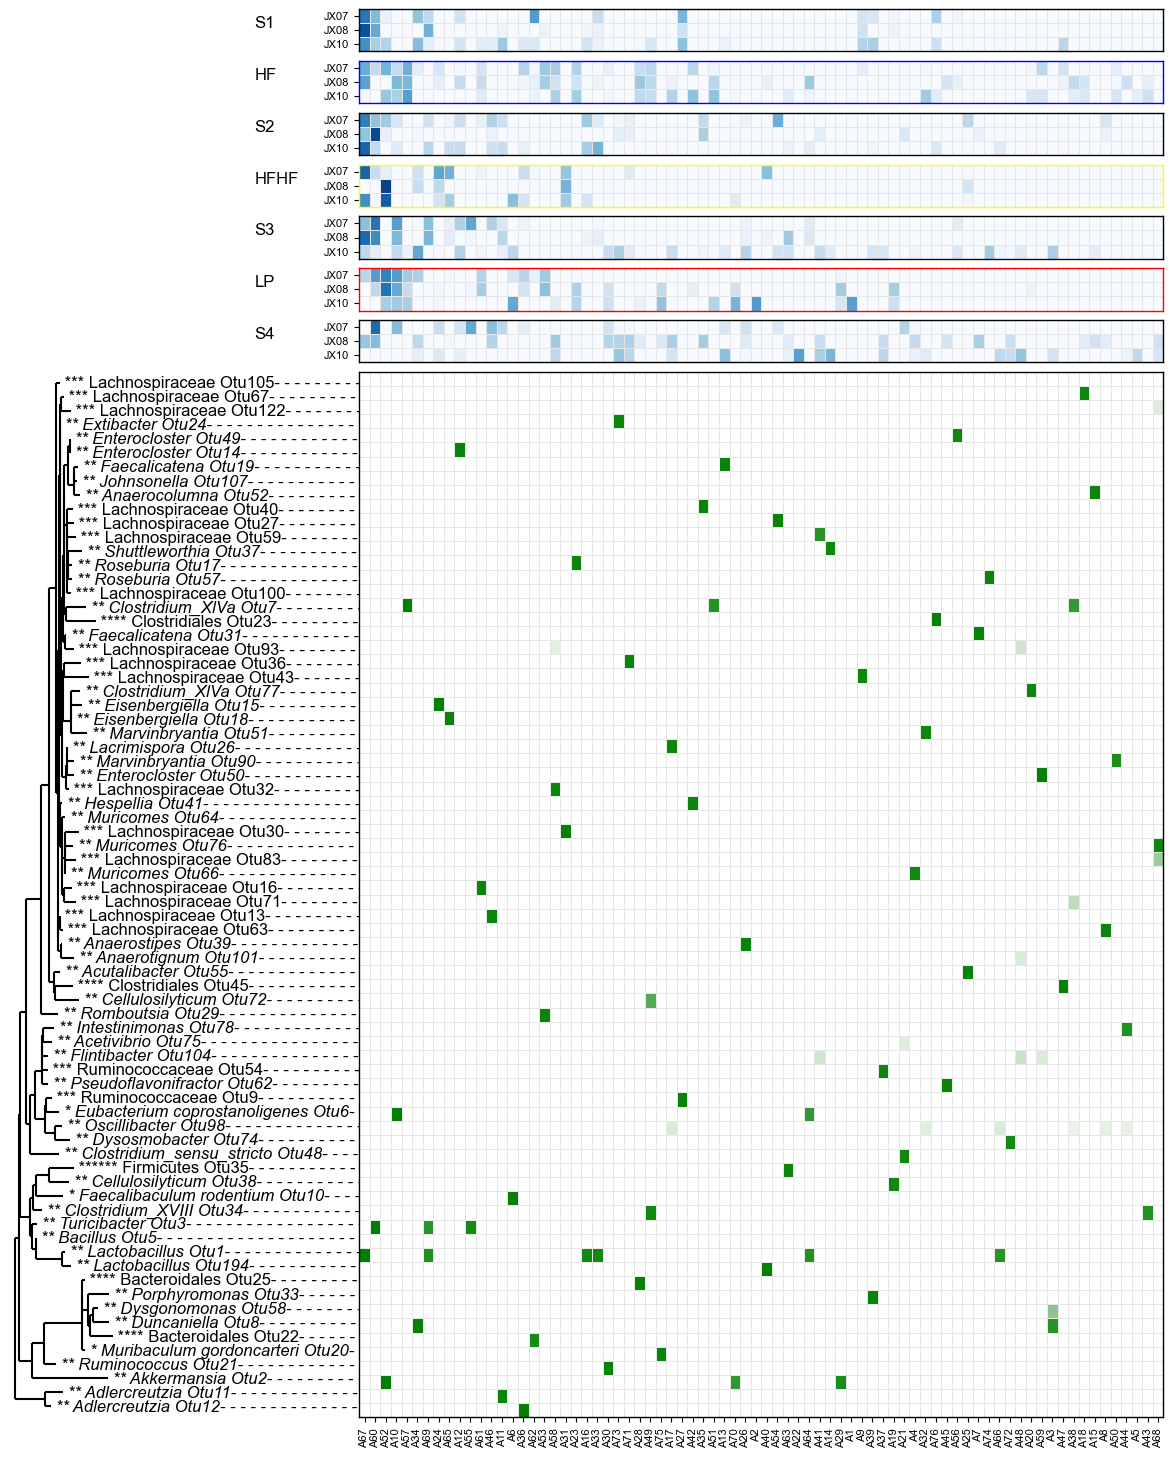

In [46]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [nsubj/notu_max]*ntime
hratios.append(notus/notu_max)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=ntime+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.05)

# create subplots, get axes
ax_betas = []
for i in range(ntime):
    ax_betas.append(fig.add_subplot(gs[i,2]))
ax_tree = fig.add_subplot(gs[-2,0])
ax_theta = fig.add_subplot(gs[-2,2])

# plot assemlage proportions
beta_order = vis.get_abundance_order(betadf)

for i,t in enumerate(times):
    ax_betas[i]=vis.plot_all_subject_proportions_at_timepoint(ax_betas[i], betadf, t, order=beta_order, vmin=-2)
    ax_betas[i].set_xticks([])
    ax_betas[i].set_yticklabels(ax_betas[i].get_yticklabels(), rotation=0, fontsize=subfontsize)
    ax_betas[i].set_ylabel(f"{diets[i]}", rotation=0, labelpad=50, ha = 'left', fontsize=fontsize)
    ax_betas[i].set_xlabel("")
    ax_betas[i] = vis.add_border(ax_betas[i], color=diet_colors[i])
    
    
# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=vis.plot_assemblages(ax_theta, theta_zsparse2, otu_order, beta_order) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = vis.add_border(ax_theta)
plt.savefig(outpath / "mouse_data_cutoff_zscore2.png", bbox_inches="tight")

original tree size: 1406
pruned tree size: 74


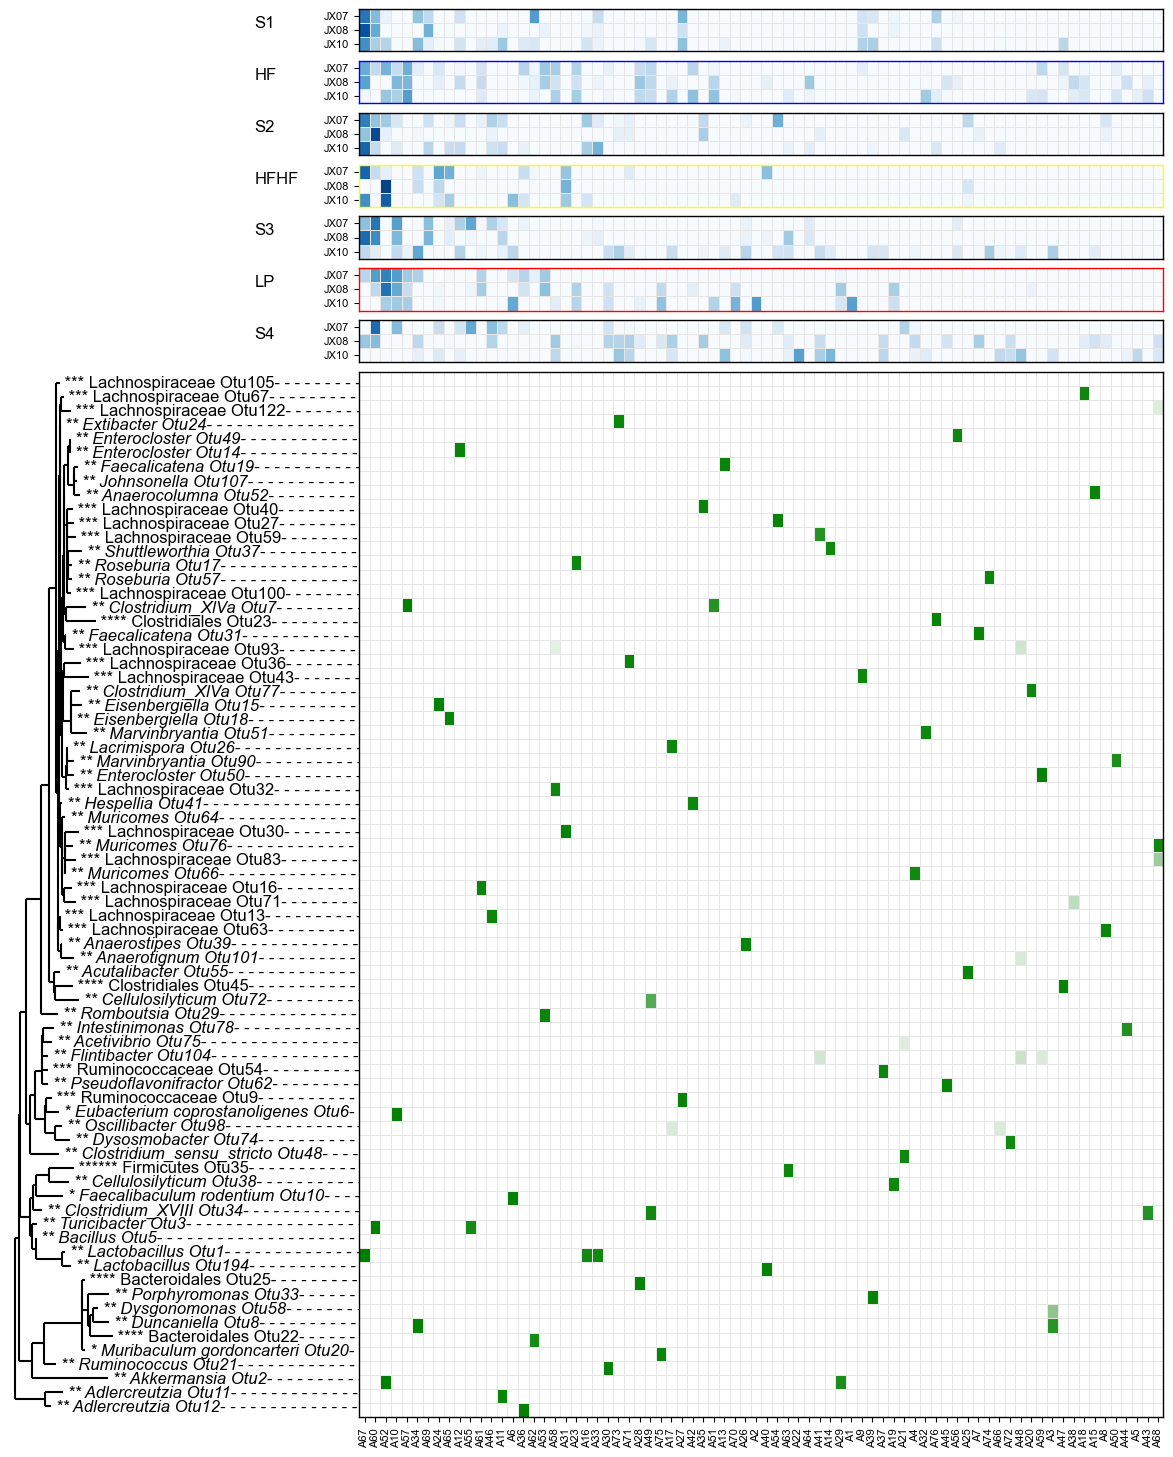

In [47]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [nsubj/notu_max]*ntime
hratios.append(notus/notu_max)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=ntime+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.05)

# create subplots, get axes
ax_betas = []
for i in range(ntime):
    ax_betas.append(fig.add_subplot(gs[i,2]))
ax_tree = fig.add_subplot(gs[-2,0])
ax_theta = fig.add_subplot(gs[-2,2])

# plot assemlage proportions
beta_order = vis.get_abundance_order(betadf)

for i,t in enumerate(times):
    ax_betas[i]=vis.plot_all_subject_proportions_at_timepoint(ax_betas[i], betadf, t, order=beta_order, vmin=-2)
    ax_betas[i].set_xticks([])
    ax_betas[i].set_yticklabels(ax_betas[i].get_yticklabels(), rotation=0, fontsize=subfontsize)
    ax_betas[i].set_ylabel(f"{diets[i]}", rotation=0, labelpad=50, ha = 'left', fontsize=fontsize)
    ax_betas[i].set_xlabel("")
    ax_betas[i] = vis.add_border(ax_betas[i], color=diet_colors[i])
    
    
# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=vis.plot_assemblages(ax_theta, theta_zsparse3, otu_order, beta_order) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = vis.add_border(ax_theta)
plt.savefig(outpath / "mouse_data_cutoff_zscore3.png", bbox_inches="tight")

In [48]:
zscoredf = pd.DataFrame(z, index=thetadf.index, columns=thetadf.columns)

In [49]:
# zscoredf

In [50]:
theta_zsparse2.to_csv(outpath / "mouse_assemblages_cutoff_zscore2.csv")
theta_zsparse3.to_csv(outpath / "mouse_assemblages_cutoff_zscore3.csv")

zscoredf.to_csv(outpath / "mouse_zscores.csv")

# TODO: compare scaling to human dataset fig; and subfigs

# output to csv files

In [51]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,10,JX07,A1,0.000391,-3.407809
1,10,JX07,A2,0.000488,-3.311654
2,10,JX07,A3,0.000333,-3.477694
3,10,JX07,A4,0.001330,-2.876205
4,10,JX07,A5,0.000473,-3.325216
...,...,...,...,...,...
1591,76,JX10,A72,0.029749,-1.526530
1592,76,JX10,A73,0.059731,-1.223798
1593,76,JX10,A74,0.006152,-2.211019
1594,76,JX10,A75,0.000311,-3.507710


In [52]:
outpath

WindowsPath('figs_mouse_results')

In [53]:
thetadf

,,,,,,,,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A67,A68,A69,A70,A71,A72,A73,A74,A75,A76
Otu,Domain,Phylum,Class,Order,Family,Genus,Species,,,,,,,,,,,,,,,,,,,,,
Otu19,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Faecalicatena,na,0.010111,0.003556,2.036655e-02,0.002388,0.056136,0.001519,0.000031,0.000015,0.010897,0.001331,...,0.000013,0.000762,2.945226e-05,0.000013,0.005112,0.002800,0.003852,0.005529,0.000079,0.000144
Otu37,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Shuttleworthia,na,0.000006,0.003600,2.690324e-02,0.000120,0.036995,0.000038,0.000074,0.000019,0.000124,0.000041,...,0.000017,0.019934,7.218846e-06,0.000676,0.001254,0.014006,0.001708,0.000071,0.000013,0.000522
Otu24,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Extibacter,na,0.007992,0.000301,5.589748e-02,0.009804,0.032306,0.002246,0.015275,0.006368,0.000057,0.000019,...,0.000013,0.008032,1.060503e-06,0.003305,0.006466,0.009908,0.833621,0.007908,0.000012,0.000058
Otu15,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Eisenbergiella,na,0.015655,0.008216,2.615866e-03,0.000128,0.054524,0.001059,0.000165,0.002317,0.003416,0.000178,...,0.000005,0.000021,4.925449e-05,0.064305,0.002055,0.017507,0.000818,0.001612,0.005467,0.000062
Otu22,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,na,na,na,0.000033,0.000340,2.245967e-05,0.002628,0.000037,0.000011,0.000395,0.000025,0.003234,0.000017,...,0.000019,0.000009,6.983464e-04,0.000014,0.000383,0.000042,0.005061,0.000074,0.000078,0.001521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Otu52,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Anaerocolumna,na,0.000001,0.000026,3.260505e-03,0.000006,0.003885,0.000024,0.000506,0.024359,0.000014,0.000013,...,0.000039,0.009235,4.056917e-06,0.000001,0.002252,0.006642,0.008798,0.000112,0.000232,0.000107
Otu39,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Anaerostipes,na,0.000261,0.000174,4.348657e-03,0.001921,0.004570,0.000030,0.001728,0.000027,0.000005,0.000010,...,0.000039,0.000018,4.019624e-05,0.000026,0.000031,0.000012,0.000871,0.000734,0.000178,0.000037
Otu98,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Oscillibacter,na,0.001599,0.009965,1.258477e-03,0.000897,0.006409,0.000071,0.000028,0.011087,0.000036,0.000044,...,0.000004,0.000031,7.428812e-07,0.002848,0.000036,0.001037,0.000010,0.000025,0.000048,0.000013


In [54]:
betadf.to_csv(outpath / "mouse_all_subject_assemblage_proportions.csv")

In [55]:
thetadf.to_csv(outpath / "assemblages.csv")

In [56]:
# avebeta

#### add stats

In [57]:
beta = avebeta.T
beta['Min'] = beta.min(axis=1)
beta['Max'] = beta.max(axis=1)
beta['Mean'] = beta.mean(axis=1)
beta['Variance of log'] = np.log(beta).var(axis=1)
beta = beta.T

In [58]:
beta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A7,A70,A71,A72,A73,A74,A75,A76,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
10,0.000492,0.003277,0.026784,0.016043,0.006977,0.000470,0.002363,0.015284,0.000668,0.000670,...,0.002640,0.000645,0.000565,0.002032,0.001512,0.003656,0.006092,0.024695,0.003389,0.030445
18,0.000122,0.051900,0.001741,0.014808,0.000592,0.004103,0.000281,0.005545,0.022326,0.017608,...,0.000618,0.005826,0.003463,0.003098,0.000388,0.000896,0.003115,0.006149,0.000358,0.005395
35,0.000048,0.013616,0.019843,0.020218,0.003180,0.000114,0.006014,0.035829,0.002962,0.001194,...,0.006868,0.000368,0.011192,0.002335,0.010034,0.004450,0.003015,0.006556,0.015132,0.003483
43,0.000025,0.005481,0.001229,0.001689,0.000729,0.000063,0.000621,0.008789,0.000581,0.000554,...,0.000357,0.007979,0.009474,0.000222,0.002074,0.001560,0.005253,0.000077,0.000501,0.001570
57,0.000592,0.081146,0.024503,0.033072,0.006885,0.008811,0.006114,0.007039,0.011030,0.001142,...,0.004997,0.000281,0.007477,0.003883,0.016120,0.018465,0.004710,0.000088,0.001067,0.000706
65,0.044096,0.101179,0.003706,0.002335,0.006988,0.003298,0.000544,0.000259,0.002667,0.000669,...,0.001212,0.041367,0.005334,0.001636,0.001885,0.001279,0.036045,0.000018,0.000617,0.002978
76,0.000119,0.030408,0.018399,0.013211,0.031694,0.029424,0.011292,0.004681,0.025645,0.005991,...,0.019375,0.000110,0.031265,0.019144,0.036857,0.005166,0.008062,0.000052,0.005630,0.000629
Min,0.000025,0.003277,0.001229,0.001689,0.000592,0.000063,0.000281,0.000259,0.000581,0.000554,...,0.000357,0.000110,0.000565,0.000222,0.000388,0.000896,0.003015,0.000018,0.000358,0.000629
Max,0.044096,0.101179,0.026784,0.033072,0.031694,0.029424,0.011292,0.035829,0.025645,0.017608,...,0.019375,0.041367,0.031265,0.019144,0.036857,0.018465,0.036045,0.024695,0.015132,0.030445


In [59]:
beta = beta.loc[:,thetadf.columns]

In [60]:
beta.to_csv(outpath / "mouse_average_assemblage_proportions.csv")

#### output bayes factors

In [61]:
pertsdf

,P1,P2,P3
A1,2.971620,2.640027,625.652710
A2,3.923855,3.964989,2159.749512
A3,2.907442,3.083910,3.269230
A4,2.746188,1.826614,2.431775
A5,6.023514,2.898376,3.637626
...,...,...,...
A72,3.238622,3.360882,3.568530
A73,6.738834,2.843930,5.138291
A74,3.501268,2.905026,3.239553
A75,2.782486,2.695037,12.365883


In [62]:
mapper={'P1': 'HF', 'P2': 'HFHF', 'P3': 'LP'}

In [63]:
bayes = pertsdf.rename(columns=mapper)

In [64]:
bayes

,HF,HFHF,LP
A1,2.971620,2.640027,625.652710
A2,3.923855,3.964989,2159.749512
A3,2.907442,3.083910,3.269230
A4,2.746188,1.826614,2.431775
A5,6.023514,2.898376,3.637626
...,...,...,...
A72,3.238622,3.360882,3.568530
A73,6.738834,2.843930,5.138291
A74,3.501268,2.905026,3.239553
A75,2.782486,2.695037,12.365883


In [65]:
bayes.to_csv(outpath / "perturbation_bayes_factors.csv")

### get relative abundances

In [66]:
def get_bulk_relative_abundances(reads, times, subjects, taxonomy):
    num_otus = taxonomy.shape[0]
    multiind = pd.MultiIndex.from_frame(taxonomy)
    ntime = len(times)
    
    radfs = {}
    for s in subjects:
        ra = np.zeros((ntime, num_otus))
        for i,t in enumerate(times):
            counts = reads[t][s].cpu().detach().clone().numpy()
            rabun = counts/counts.sum(axis=1, keepdims=True)
            bulk_rabun = np.mean(rabun, axis=0)
            ra[i,:] = bulk_rabun
        df = pd.DataFrame(data=ra.T, index=multiind, columns=times)
        radfs[s] = df
    return radfs

In [67]:
reads = data['count_data'] #.cpu().detach().clone().numpy()
bulktemp = get_bulk_relative_abundances(reads, times, subjects, taxonomy.reset_index())

In [68]:
bulktemp.keys()

dict_keys(['JX07', 'JX08', 'JX10'])

In [69]:
for s in subjects:
    bulktemp[s].to_csv(outpath / f"relative_abundances_{s}.csv")

In [70]:
bulktemp['JX07'].head()

,,,,,,,,10,18,35,43,57,65,76
Otu,Domain,Phylum,Class,Order,Family,Genus,Species,,,,,,,
Otu19,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Faecalicatena,na,3.582813e-03,0.000931,0.006646,0.000002,0.003277,0.002936,0.023701
Otu37,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Shuttleworthia,na,0.000000e+00,0.001765,0.000021,0.000000,0.010242,0.010228,0.002908
Otu24,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Extibacter,na,3.333825e-04,0.000006,0.012511,0.003272,0.001631,0.000008,0.012607
Otu15,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Eisenbergiella,na,1.477478e-07,0.020445,0.000036,0.121506,0.009743,0.003594,0.026936
Otu22,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,na,na,na,1.082325e-01,0.012194,0.002825,0.015431,0.000002,0.014764,0.001006


### average over subjects

In [71]:
mbulk = bulktemp[subjects[0]].copy()
for i in range(1,len(subjects)):
    mbulk = mbulk + bulktemp[subjects[i]]

In [72]:
mouse_ave = mbulk.copy()/len(subjects)

In [73]:
mouse_ave.to_csv(outpath / "relative_abundances_subject_average.csv")

In [74]:
# thetadf
thetaflat = np.reshape(thetadf.values, (-1,))

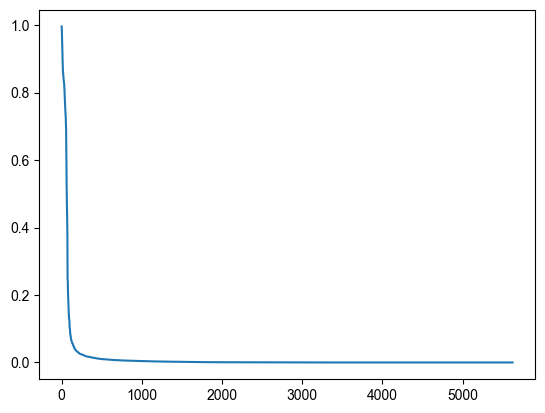

In [75]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat))

(0.0, 0.1)

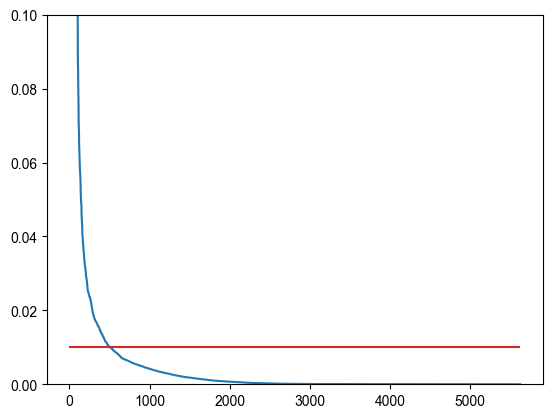

In [76]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat))
ax.hlines(0.01, 0, len(thetaflat), color='tab:red')
ax.set_ylim(0,0.1)